# An Exquisitely Commented SVM Toolkit

* Original notebook by Natalia Zhang <wenshuo.zhang@gmail.com>
* Module documentation http://scikit-learn.org/stable/modules/svm.html
* Move things around and/or modify as needed
* Copiously annotated so that you can control-F to any keyword that you need

## Contents
* Classification
* 1-Class Outlier Detection
* Hyperparameters & Metrics
* Example: Boston Housing Data
* Appendix
    - Additional SVM Methods
    - Additional Kernels
    - Support Vector Regression

## Classification

SVM is more immune to issues of (multi)collinearity because it models the separation _between_ classes instead of modeling the classes themselves. It also can handle data that has a lot of features (e.g. text data). The downside is that the initial model can be computationally expensive to run, but predictions should be pretty fast once you've hurried up and waited. 

**When selecting a kernel:**
* What's a good separator/classification rule of thumb?
* Kernel should reflect a family of transformations that do not change your problem fundamentally (but which ones do you care about?)

Think of the kernel as a similarity measure. Choose one according to expert knowledge if you can. RBF (Gaussian) kernel is the **default** in SVM and is a good one to start with, especially since linear kernel is a special case of the RBF and would be covered by it.

One last caveat: unless you're using a linear kernel, it's usually not possible to directly analyze feature importance. The alternative is to go in the other direction (remember, SVM increases dimensionality to make it easier to draw hyperplanes) and perform dimensionality reduction *or* by doing feature extraction.

### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(FILL_IN_FEATURES, FILL_IN_LABELS, random_state=ENTER_INT)

### Actual Code for Actual Classification

In [ ]:
#Linear classification
#If you have millions of samples and/or features, use LinearSVC instead of SVC

from sklearn import svm

svmmodel = svm.SVC(kernel = 'linear') #linear mode
svmmodel = svmmodel.fit(X_train, Y_train) #Line 1 and Line 2 can be combined
predictions = svmmodel.predict(X_test) #predict with test data, returns class labels

#Often used options
svmmodel = svmmodel.SVC(kernel = 'linear', class_weights='balanced') #auto-weights for imbalanced data, can provide dict of custom weights
svmmodel = svmmodel.SVC(kernel = 'linear', probability = True) #add probabilities, but they can be inaccurate
svmmodel = svmmodel.SVC(kernel = 'linear', C = 1) #Change C to allow for overlapping datasets. Default is 1, C can range from 0 to 1+ 

#need probabilities? Run with probability = True
svmmodel.predict_proba(X_test) #uses CV to generate, so results will be slightly different
svmmodel.score(X_train, Y_train) #returns mean accuracy of data & labels

In [ ]:
#Use Stochastic Gradient Descent module on sparse data for NLP.
#Data should have been previously tokenized/cleaned/converted to count vectors
#You can't generate probability estimates with the SGD method!

from sklearn import linear_model

svmmodel = linear_model.SGDClassifier()
svmmodel = svmmodel.fit(X_train, Y_train)
predictions = svmmodel.predict(X_test) #predict with test data

#Customizable version
svmmodel = linear_model.SGDClassifier(loss = "hinge", penalty = "l2", class_weights="balanced")

#Loss: Hinge is default. Anything else is not an SVM!
#Penalty: L2 default, L1 or ElasticNet does better feature selection
#class weights: see above
#You may care about random_state, specify int for reproducible data shuffling

In [ ]:
#RBF/Gaussian, DEFAULT OPTION, draws normal curves around data points 

from sklearn import svm

svmmodel = svm.SVC(kernel = 'rbf')
svmmodel = svmmodel.fit(X_train, Y_train) #Actually train your model on training data
predictions = svmmodel.predict(X_test) #predict with test data

#Often used options

svmmodel = svm.SVC(kernel = 'rbf', class_weights='balanced') #auto-weights for imbalanced data, can provide dict of custom weights
svmmodel = svm.SVC(kernel = 'rbf', probability = True) #add probabilities, but they can be inaccurate
svmmodel = svm.SVC(kernel = 'rbf', C = 1) #Change C to allow for overlapping datasets. Default is 1, C can range from 0 to 1+ 
svmmodel = svm.SVC(kernel = 'rbf', gamma = 'auto') #specifies kernel coef, auto is default, but can give float

Usually you'll only need the linear or the Gaussian kernel. Polynomial and sigmoid kernel code is in the Appendix, as are the additional SVM methods.

### Feature Importance

As mentioned earlier, sometimes you do care about feature importance. This is not a good algorithm to use if you want an easy explanation out of anything except the linear kernel.

In [ ]:
#SVM can access weights through a built-in function.
#Coefficients may differ based on the kernel that you're using, because linearSVC uses one-against-multi 
#as compared to the regular linear kernel (in libsvm) using one-against-one.
#Note, however, that this is *only* for the multiclass case

svmcoef = svmmodel.coef_ #you may want to ravel it (flatten into easy numpy array)


#potential way to ID most important features for SVC, but I haven't tested this

from sklearn import svm
from sklearn.feature_selection import RFE

svmmodel = SVC()
rfe = RFE(svmmodel, "# features to be selected without quotes")
rfe.fit(X, Y)
print(rfe.support_)

## One-Class Outlier Detection

This is just an SVM and offers the same flexibility as the multiclass cases above. We do need to care about **nu**, which is an upper bound on the fraction of margin errors and a lower bound on the fraction of support vectors relative to the total number of training examples

If nu = 0.05, at most 5% of training examples will be found to be misclassified
& at least 5% of training examples are support vectors

In [13]:
from sklearn import svm

svmmodel = svm.OneClassSVM(kernel = "FILL_ME_IN", nu="FILL ME IN WITHOUT QUOTES")
svmmodel = svmmodel.fit(X_train)
outliers = svmmodel.fit_predict(X_train) #-1 for outlier, 1 for inliers
predictions = svmmodel.predict(X_test) #returns class labels. This may not be necessary

#nu is between 0 and 1. Default is 0.5

## Validation & Metrics

### Optimizing Hyperparameters

Common ones:

* kernel
* gamma
* class weights
* C

In [ ]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import Parameter Grid

#specify either a list of parameters or a ParamGrid
parameters = {'hyperparam1': [value1, value2,value3], 'hyperparam2':[value1, value2]}
#a ParamGrid is a cross product of whatever is in a dict together/,
#so the list below generates 9 combinations for grid search,
parameters = ParameterGrid({'hyperparam1': [value1,value2,value3], 'hyperparam2': [value1,value2,value3]})

svmmodel = svm.SVC()
gridsearch = GridSearchCV(svmmodel, parameters, cv=5)

#use best set of parameters
print(gridsearch.best_params_)
model = gridsearch.best_estimator_
Y_test_predicted = model.predict(X_test)

#You may want to specify a pipeline if you're applying transforms to your features
#e.g. CountVectorizer or Tfidfvectorizer. Otherwise this is optional
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(NAME_OF_TRANSFORM, svmmodel)

### Metrics

### Simple CV

* Scoring: accuracy, f1, prevision, recall, roc_auc
* stick to 'f1' unless you know what you're doing with f1_micro and f1_macro
* Full list: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

scores = cross_val_score(svm, X, Y, cv=5, scoring='f1')

#X should be features of ALL data
#Y should be labels of ALL data
#CV = number of slices. I like 5, 3 is default.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_test_predicted, target_names=['LABEL_NAME_1','LABEL_NAME_2']))

#you may want to just generate a list of target_names to pass into different things

The problem I see with classification_report is that the report is not as intuitive as a confusion matrix because it reports a separate metric for each _class_ and includes a bunch of metrics that we may not necessarily need.

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(Y_test, Y_test_predicted)
sns.heatmap(matrix.T, square = True, annot=True, fmt='d',cbar=False, 
            xticklabels=TARGET_NAMES_LIST, yticklabels=TARGET_NAMES_LIST)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

### Example: Boston Housing Data

We might as well aim for a real example and examine some statistics. Borrowed this strategy from Michelle. Thanks!

In [35]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Oh hey it's the Boston Housing Data
iris = datasets.load_iris()

#Now let's split
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, random_state=2047)


In [32]:
#now let's do a linear kernel and see what happens

from sklearn import svm

svmmodel = svm.SVC(kernel = 'linear') #linear mode
svmmodel = svmmodel.fit(X_train, Y_train) #Line 1 and Line 2 can be combined
Y_train_predictions = svmmodel.predict(X_train)
Y_test_predictions = svmmodel.predict(X_test) #predict with test data, returns class labels

In [43]:
print(svmmodel.coef_)

[[-0.04619348  0.52133922 -1.00307924 -0.4641441 ]
 [-0.00708258  0.17885072 -0.53832399 -0.29218158]
 [ 0.59243325  0.96037137 -2.0072457  -1.97539481]]


I used a linear model here specifically so that we can look at coefficient values. Because libsvm uses a one-against-one scenario, we have three combinations of coefficients for generating support vectors: 0 against 1, 1 against 2, and 0 against 2.

What are they, though? Scikit-learn is obtuse and won't return the feature names outright, so we'd have to dig around shallowly. The Iris data does not have labels on the feature array, so you'd have to go dig inside that dataset to find the description. A common strategy is to 1. harvest the feature names from the column labels 2. get the SVM linear kernel coefficients, 3. then loop and print.

Text(91.68,0.5,'Predicted Label')

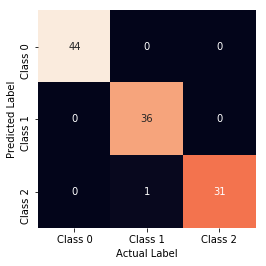

In [36]:
from sklearn.metrics import confusion_matrix

target_names = ["Class 0", "Class 1","Class 2"]
#training error

matrix = confusion_matrix(Y_train, Y_train_predictions)
sns.heatmap(matrix.T, square = True, annot=True, fmt='d',cbar=False, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

Text(91.68,0.5,'Predicted Label')

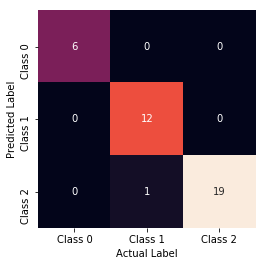

In [37]:
#test error

matrix = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(matrix.T, square = True, annot=True, fmt='d',cbar=False, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

To demonstrate what I mean by the classification report being hard to interpret, here's an example

In [41]:
from sklearn.metrics import classification_report
print(classification_report(Y_train,Y_train_predictions, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        44
     Class 1       1.00      0.97      0.99        37
     Class 2       0.97      1.00      0.98        31

   micro avg       0.99      0.99      0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112



In [42]:
print(classification_report(Y_test,Y_test_predictions, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         6
     Class 1       1.00      0.92      0.96        13
     Class 2       0.95      1.00      0.97        19

   micro avg       0.97      0.97      0.97        38
   macro avg       0.98      0.97      0.98        38
weighted avg       0.97      0.97      0.97        38



## Appendix

### Additional SVM Methods

Different SVM methods use different classification strategies.

In [ ]:
from sklearn import svm

svm = LinearSVC() 

#options similar to SVC() with a linear kernel, no other kernerl!
#liblinear instead of libsvm
#multiclass implementation is one-vs-the-rest, not one-against-one
#scales better with large numbers of features and samples, also more options
#may work better with NLP if you don't use SGDClassifier


In [ ]:
from sklearn import svm

svm = NuSVC(nu = 0.5) #0.5 is default!

#only differenc is that it uses a parameter to control # support vectors
#everything else similar!

### Additional Kernels

In [ ]:
#polynomial model, so presumably can draw complicated curves

from sklearn import svm

svm = svm.SVC(kernel = 'poly')
svm.fit(X_train, Y_train) #Actually train your model on training data
svm.predict(X_test) #predict with test data

#Often used options
svm = svm.SVC(kernel = 'poly', class_weights='balanced') #auto-weights for imbalanced data, can provide dict of custom weights
svm = svm.SVC(kernel = 'poly', probability = True) #add probabilities, but they can be inaccurate
svm = svm.SVC(kernel = 'poly', C = 1) #Change C to allow for overlapping datasets. Default is 1, C can range from 0 to 1+ 
svm = svm.SVC(kernel = 'poly', gamma = 'auto') #specifies kernel coef, auto is default, but can give float

In [ ]:
#Sigmoid kernel, similar to sigmoid function in logistic regression
from sklearn import svm

svm = svm.SVC(kernel = 'sigmoid')
svm.fit(X_train, Y_train) #Actually train your model on training data
svm.predict(X_test) #predict with test data

#Often used options
svm = svm.SVC(kernel = 'sigmoid', class_weights='balanced') #auto-weights for imbalanced data, can provide dict of custom weights
svm = svm.SVC(kernel = 'sigmoid', probability = True) #add probabilities, but they can be inaccurate
svm = svm.SVC(kernel = 'sigmoid', C = 1) #Change C to allow for overlapping datasets. Default is 1, C can range from 0 to 1+ 
svm = svm.SVC(kernel = 'sigmoid', gamma = 'auto') #specifies kernel coef, auto is default, but can give float

### Support Vector Regression

I'm not sure why you'd ever want to do SVR, but here's some skeleton code

In [ ]:
from sklearn import svm

svrmodel = svm.SVR()
svrmodel = svrmodel.fit(X_train, Y_train)
predictions = svrmodel.predict(X_test)
svrmodel.score(X_train, Y_train) #gets R^2 of the prediction

# kernels: linear, rbf (DEFAULT), poly, sigmoid
# No class weight options!